## Import

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'font.size': 32})
plt.rcParams["figure.figsize"] = (12,8)
import torch
import numpy as np
import scipy.signal
import scipy.io
import pandas as pd
import itertools
from itertools import product

from tqdm.notebook import tqdm, trange

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

import os
import copy
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision
from torchvision import transforms, datasets
import torchvision.transforms as T

from torchsummary import summary

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from tqdm.notebook import tqdm, trange

import pandas as pd

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import random

In [ ]:
import h5py

In [ ]:
def torch_stats(): 
    torch_version = ".".join(torch.__version__.split(".")[:2])
    print('torch version:',torch_version)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using device:', device)
    dtype = torch.float32
        
    if device.type == 'cuda':
        cuda_version  = torch.__version__.split("+")[-1]
        print("cuda: ", cuda_version)
        
        torch.set_default_tensor_type(torch.cuda.FloatTensor)
        print('Cuda is available:',torch.cuda.is_available())

        n_devices = torch.cuda.device_count()
        print('number of devices: %d'%(n_devices))

        for cnt_device in range(n_devices):
            print(torch.cuda.get_device_name(cnt_device))
            print('Memory Usage:')
            print('Allocated:', round(torch.cuda.memory_allocated(cnt_device)/1024**3,1), 'GB')
            print('Cached:   ', round(torch.cuda.memory_reserved(cnt_device)/1024**3,1), 'GB')
        # dtype = torch.cuda.FloatTensor
        
    torch.set_default_dtype(dtype) # float32
    print('default data type:',dtype)
    
    num_workers=os.cpu_count()
    print ('available number of workers (CPU cores):',num_workers)
    
    return device, dtype, num_workers
#-------------------------------
def torch_seed(seed = 42, deterministic = True):
    random.seed(seed) # random and transforms
    np.random.seed(seed) #numpy
    torch.manual_seed(seed) #cpu
    torch.cuda.manual_seed(seed) #gpu
    torch.backends.cudnn.deterministic=deterministic #cudnn    
    
device, dtype, num_workers = torch_stats()
torch_seed(seed = 42, deterministic = True)

torch version: 1.11
Using device: cuda
cuda:  cu113
Cuda is available: True
number of devices: 1
Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
default data type: torch.float32
available number of workers (CPU cores): 2


In [ ]:
stable = True # Set to True for latest pip version or False for main branch in GitHub
!pip install {"tsai -U" if stable else "git+https://github.com/timeseriesAI/tsai.git"} >> /dev/null

In [ ]:
def autocor(x, n_fft = None):
    if n_fft is None: n_fft =  2*x.shape[1]
    x   = torch.atleast_2d(torch.as_tensor(x))
    sp  = torch.fft.fft(x, n =n_fft, dim = -1) 
    sp  = (sp*sp.conj()).real     
    return torch.fft.ifft(sp, n =n_fft, dim = -1)[:,:n_fft//2].real 

def square_filter(x, fp, lp, real_val = True):
    x     = torch.atleast_2d(torch.as_tensor(x))
    n_fft =  x.shape[1]
    sp    = torch.fft.fft(x, n =n_fft, dim = -1)  
    sp    = _square_filter_(sp, fp, lp, n_fft, real_val = True)
    out   = torch.fft.ifft(sp, n =n_fft, dim = -1)
    if real_val: out = out.real
    return out

def hilbert(x):
    n_fft =  x.shape[1]
    return square_filter(x, 0, n_fft//2, real_val = False)

def _square_filter_(sp, fp, lp, n_fft, real_val = True):
    sp[:,:fp] = 0
    sp[:,lp:n_fft//2] = 0
    if real_val:
        sp[:,n_fft - fp +1:] = 0    
        sp[:,n_fft//2:n_fft//2+(n_fft//2-lp) +1 ] = 0
    else:
        sp[:,n_fft//2:] = 0
    return sp

def transform(x, fp, lp):
    n_fft =  2*x.shape[1]
    x     = torch.atleast_2d(torch.as_tensor(x))
    sp    = torch.fft.fft(x, n =n_fft, dim = -1) 
    sp    = _square_filter_(sp, fp, lp, n_fft, real_val = True)
    sp    = (sp*sp.conj()).real     
    return torch.fft.ifft(sp, n =n_fft, dim = -1)[:,:x.shape[1]].real 

def transform(x, fp, lp):    
    return square_filter(x, fp, lp, real_val = True)

Data import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
num_workers = 0

In [ ]:
fs = 50e3

In [ ]:
dataset = h5py.File('/content/drive/MyDrive/dataset_.hdf5', 'r')

In [ ]:
def printname(name):
    print(name)
dataset.visit(printname)

x_test_1
x_test_2
x_train_1
x_train_2


In [ ]:
dataset['x_train_1'].shape

(20, 12500000)

In [ ]:
class HD5Dataset(nn.Module):

    def __init__(self, ds, parts, signal_size, transform=None, device = None):
        self.ds = ds
        self.parts = parts
        self.signal_size = signal_size
        self.transform = transform
        self._len = 0
        self.ncls  = 0
        self.signals_in_class = []
        self.signals_in_part  = []
        self.classes_in_part  = []
        self.n_parts = len(self.parts)
        for part in self.parts:
            shape = self.ds[part].shape
            self.signals_in_part += [shape[0]*(shape[1]//self.signal_size)]
            self.ncls  += shape[0]
            self.signals_in_class +=[shape[1]//self.signal_size]
            self._len += self.signals_in_part[-1]
            self.classes_in_part +=[shape[0]]
        # self.classes_in_part = torch.tensor(self.classes_in_part)
        # self.signals_in_part = torch.tensor(self.signals_in_part) 
        # self.signals_in_class = torch.tensor(self.signals_in_class) 
        if device is not None:
            self.device = device
        else:
          self.device = 'cpu'

    def incpect(self):
        print('signals_in_part',self.signals_in_part)
        print('signals_in_class',self.signals_in_class)
        print('n cls',self.ncls)
        print('len',self._len)
        print('n_parts',self.n_parts)
        print('classes_in_part',self.classes_in_part)
    
    def idx_2_position(self, idx):
        part = idx//self.signals_in_part[0]
        idx  = idx - self.signals_in_part[0]*part
        source = idx// self.signals_in_class[part] 
        segment = idx - self.signals_in_class[part] *source
        fp = segment*self.signal_size
        lp = (segment+1)*self.signal_size
        return part, source, fp, lp
    
    def position_2_class(self, part, source):
        return sum(self.classes_in_part[:part])+source

    def __len__(self):
        return self._len

    def __getitem__(self, idx):
        part, source, fp, lp = self.idx_2_position(idx)
        signal = self.ds[self.parts[part]][source,fp:lp]
        label  = self.position_2_class(part, source)

        if self.transform:
            signal = self.transform(signal)

        return torch.as_tensor(signal).to(self.device).unsqueeze(0), torch.as_tensor(label).to(self.device)

In [ ]:
ds = HD5Dataset(dataset,parts = ['x_train_1','x_train_2'], signal_size=int(10e3))
ds.incpect()

signals_in_part [25000, 25000]
signals_in_class [1250, 1250]
n cls 40
len 50000
n_parts 2
classes_in_part [20, 20]


In [ ]:
ds[10000]

(tensor([[ 0.0440, -0.0097, -0.0260,  ...,  0.1091,  0.1023,  0.0967]],
        device='cpu'), tensor(8, device='cpu'))

In [ ]:
BATCH_SIZE = 128
if torch.cuda.is_available():
    kwarg = {'generator':torch.Generator(device='cuda')}
else:
    kwarg = {'generator':torch.Generator(device='cpu')}

train_set, val_set = torch.utils.data.random_split(ds, [int(len(ds)*0.7), len(ds)-int(len(ds)*0.7)], **kwarg)

In [ ]:
test_set = HD5Dataset(dataset,parts = ['x_test_1','x_test_2'], signal_size=int(10e3))

In [ ]:
trainloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,  **kwarg)
valloader   = torch.utils.data.DataLoader(val_set,   batch_size=BATCH_SIZE, shuffle=False, **kwarg)
testloader  = torch.utils.data.DataLoader(test_set,  batch_size=BATCH_SIZE, shuffle=False, **kwarg)

In [ ]:
x,y = next(iter(trainloader))
print(x.shape, y.shape)

torch.Size([128, 1, 10000]) torch.Size([128])


In [ ]:
from tsai.all import *
my_setup()

os             : Linux-5.4.188+-x86_64-with-Ubuntu-18.04-bionic
python         : 3.7.13
tsai           : 0.3.1
fastai         : 2.6.3
fastcore       : 1.4.4
torch          : 1.11.0+cu113
device         : 1 gpu (['Tesla T4'])
cpu cores      : 2
RAM            : 12.68 GB
GPU memory     : [14.75] GB


In [ ]:
from fastai.vision.models.xresnet import *

In [ ]:
model = xresnet18(c_in=1, n_out=40, act_cls=nn.ReLU, ndim=1)


In [ ]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of trainable parameters for the model: %d' % (num_params))

num_params = sum(p.numel() for p in model.parameters() )
print('Number of all parameters for the model: %d' % (num_params))

Number of trainable parameters for the model: 3873416
Number of all parameters for the model: 3873416


In [ ]:
from torchsummary import summary
summary(model,(1,10000))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 32, 5000]              96
       BatchNorm1d-2             [-1, 32, 5000]              64
              ReLU-3             [-1, 32, 5000]               0
            Conv1d-4             [-1, 32, 5000]           3,072
       BatchNorm1d-5             [-1, 32, 5000]              64
              ReLU-6             [-1, 32, 5000]               0
            Conv1d-7             [-1, 64, 5000]           6,144
       BatchNorm1d-8             [-1, 64, 5000]             128
              ReLU-9             [-1, 64, 5000]               0
        MaxPool1d-10             [-1, 64, 2500]               0
           Conv1d-11             [-1, 64, 2500]          12,288
      BatchNorm1d-12             [-1, 64, 2500]             128
             ReLU-13             [-1, 64, 2500]               0
           Conv1d-14             [-1, 6

In [ ]:
LR = 0.0005

model = model.to(device)

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)


trainable_parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = optim.SGD(trainable_parameters, lr=LR, momentum=0.9)


In [ ]:
def accuracy(y_pred, y):
    cls_pred = y_pred.argmax(1, keepdim=True)    
    correct_cls = cls_pred.eq(y.view_as(cls_pred)).sum()
    acc = correct_cls.float() / y.shape[0]
    return acc
    
#-----------------------------
def train(model, dataloader, optimizer, criterion, metric, device):

    epoch_loss = 0
    epoch_acc  = 0

    model.train()

    for (x, y) in tqdm(dataloader, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred = model.forward(x)

        loss = criterion(y_pred, y)
        acc  = metric( y_pred, y)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc  += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)
#--------------------------
def evaluate(model, dataloader, criterion, metric, device):

    epoch_loss = 0
    epoch_acc  = 0

    model.eval()

    with torch.no_grad():
        
        for (x, y) in tqdm(dataloader, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred = model.forward(x)

            loss = criterion(y_pred, y)
            acc  = metric( y_pred, y)

            epoch_loss += loss.item()
            epoch_acc  += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)
#-------------------
def predicts(model, dataloader, device):

    epoch_loss = 0
    epoch_acc  = 0

    model.eval()

    y_s = []
    y_preds = []
    with torch.no_grad():
        
        for (x, y) in tqdm(dataloader, desc="Evaluating", leave=False):

            x = x.to(device)
            y = [y.to(device).data.cpu().numpy()]

            y_pred = +[ model.forward(x).data.cpu().numpy() ]

    return np.asarray(y_s), np.asarray(y_preds)
#-------------------
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
EPOCHS = 10

train_loss = torch.zeros(EPOCHS)
valid_loss = torch.zeros(EPOCHS)
train_acc  = torch.zeros(EPOCHS)
valid_acc  = torch.zeros(EPOCHS)

best_valid_loss = float('inf')
best_epoch = 0

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss[epoch], train_acc[epoch] = train(model, 
                                                trainloader, 
                                                optimizer, 
                                                criterion,
                                                accuracy,
                                                device)
    
    valid_loss[epoch], valid_acc[epoch] = evaluate(model, 
                                                   valloader, 
                                                   criterion, 
                                                   accuracy,
                                                   device)

    if valid_loss[epoch] < best_valid_loss:
        best_valid_loss = valid_loss[epoch]
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_model.pt')

    epoch_mins, epoch_secs = epoch_time(start_time, time.monotonic())
    if epoch%2 == 1:    # print every 2 epochs:
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss[epoch]:.3f} | Train Acc: {train_acc[epoch]*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss[epoch]:.3f} |  Val. Acc: {valid_acc[epoch]*100:.2f}%')

model.load_state_dict(torch.load('best_model.pt'))
test_loss, test_acc = evaluate(model, valloader, criterion, accuracy, device)
print(10*'--',f'\nbest epoch {best_epoch}: Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/274 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]

Training:   0%|          | 0/274 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 4m 17s
	Train Loss: 0.385 | Train Acc: 93.88%
	 Val. Loss: 0.354 |  Val. Acc: 94.09%


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]

Training:   0%|          | 0/274 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 4m 17s
	Train Loss: 0.351 | Train Acc: 94.28%
	 Val. Loss: 0.529 |  Val. Acc: 83.47%


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]

Training:   0%|          | 0/274 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 4m 17s
	Train Loss: 0.316 | Train Acc: 94.83%
	 Val. Loss: 0.346 |  Val. Acc: 92.11%


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]

Training:   0%|          | 0/274 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]

Training:   0%|          | 0/274 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 4m 17s
	Train Loss: 0.259 | Train Acc: 95.82%
	 Val. Loss: 0.222 |  Val. Acc: 96.17%


Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]

-------------------- 
best epoch 9: Test Loss: 0.222 | Test Acc: 96.17%


In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
test_loss, test_acc = evaluate(model, testloader, criterion, accuracy, device)
print(10*'--',f'\nbest epoch {best_epoch}: Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/391 [00:00<?, ?it/s]

-------------------- 
best epoch 9: Test Loss: 0.724 | Test Acc: 70.30%


In [ ]:
def predicts(model, dataloader, device):

    epoch_loss = 0
    epoch_acc  = 0

    model.eval()

    y_s = np.array([])
    y_preds = np.array([])
    with torch.no_grad():
        
        for (x, y) in tqdm(dataloader, desc="Evaluating", leave=False):

            x = x.to(device)
            y_s = np.append(y_s,y.to(device).data.cpu().numpy())

            y_preds = np.append(y_preds,model.forward(x).data.cpu().numpy() )
    return np.asarray(y_s), np.asarray(y_preds)

In [ ]:
y, y_pred = predicts(model, testloader, device)

Evaluating:   0%|          | 0/391 [00:00<?, ?it/s]

In [ ]:
y.shape

(50000,)

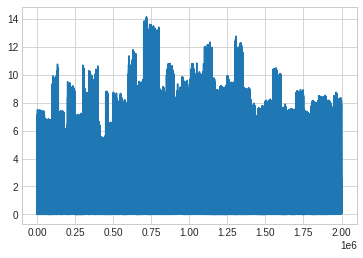

In [ ]:
plt.plot(np.abs(y_pred))